# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from statsmodels.tools import add_constant
from scipy import stats
from statsmodels.api import OLS
%matplotlib inline

C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


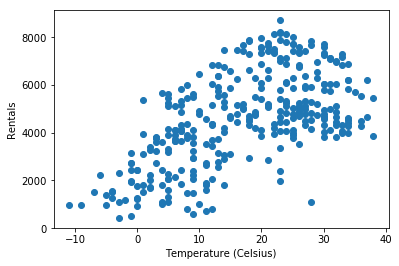

In [2]:
df_train = pd.read_csv("data/Bikeshare_train.csv")
df_test = pd.read_csv("data/Bikeshare_test.csv")
#temperature
plt.scatter(df_train['temp'], df_train['count'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Rentals')
df_train.head()

In [47]:
df_train.shape

(331, 12)

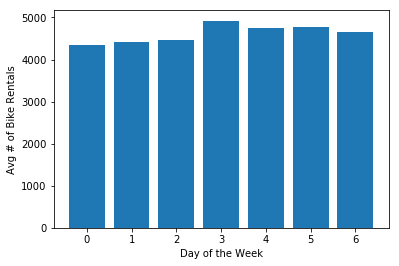

In [42]:
days_avg_count = dict()
for i in range(0,7):
    day = df_train.loc[df_train['day_of_week'] == i, 'count']
    avg = np.mean(day)
    days_avg_count[i] = avg
x, y = zip(*days_avg_count.items())
plt.bar(x, y)
plt.xlabel('Day of the Week')
plt.ylabel('Avg # of Bike Rentals');

In [5]:
no_hday = np.mean(df_train.loc[df_train['holiday'] == 0, 'count'])
hday = np.mean(df_train.loc[df_train['holiday'] == 1, 'count'])
print('Average bike rentals on a holiday:', hday)
print('Average bike rentals on a non-holiday:', no_hday)

Average bike rentals on a holiday: 4199.181818181818
Average bike rentals on a non-holiday: 4612.171875


dict_items([(0, nan), (1, 2639.722222222222), (2, 4985.7441860465115), (3, 5680.738636363636), (4, 4745.2588235294115)])


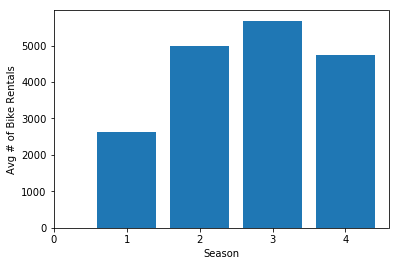

In [6]:
season_avg_count = dict()
for i in range(0,5):
    day = df_train.loc[df_train['season'] == i, 'count']
    avg = np.mean(day)
    season_avg_count[i] = avg
x, y = zip(*season_avg_count.items())
plt.bar(x, y)
plt.xticks(np.arange(0, 4+1, 1.0))
plt.xlabel('Season')
plt.ylabel('Avg # of Bike Rentals')
print(season_avg_count.items())

- How does temperature effect bike rentals?
    * Our first plot shows that as the temperature increases, so do bike rentals. There is a limit to this increase, however, which seems to be at about 22 degrees Celsius. After this point bike rentals begin to decrease as temperature increases

- Is the number of bike rentals lower than average when there is rain or snow?
    * There are no values for snow/heavy precipitation, so we do not know.

- How does the number of bike rentals vary between weekdays and weekends? 
    * Our second graph shows the average number of bikes rented on each day of the week. We were surprised to find that Wednesday had the highest average number of bike rentals. Other than this anomaly, it seems that the latter three days of the week are more popular than the first three days of the week. It seems overall that there are more bike rentals on weekdays than weekends, because Saturday has only the fourth highest average bike rentals and Sunday has the lowest average bike rentals.

- How about bike rentals on holidays?
    * We were surprised to find that the average number of bike rentals on holidays was about 400 lower than the average number of rentals on non-holidays.

- What effect does the season have on the bike rentals on a given day?
    * Finally, our last graph shows the average number of bike rentals per season. This graph surprised us the most because of the very low number that we got for spring. If we were to further investigate this anomaly we would look at the average temperature and humidity for each season, because we may not understand what each season means in terms of weather for Washington D.C.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **
    
- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [11]:
# one-hot encoding season
one_hots = pd.get_dummies(df_train['season'])
one_hots.columns = ['spring', 'summer', 'fall', 'winter']
df_train1 = df_train.join(one_hots)
df_train1 = df_train1.drop('winter', 1)

one_hots = pd.get_dummies(df_test['season'])
one_hots.columns = ['spring', 'summer', 'fall', 'winter']
df_test1 = df_test.join(one_hots)
df_test1 = df_test1.drop('winter', 1)

# encoding month
one_hotm = pd.get_dummies(df_train['month'])
one_hotm.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_train1 = df_train1.join(one_hotm)
df_train1 = df_train1.drop('Dec', 1)

one_hotm = pd.get_dummies(df_test['month'])
one_hotm.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_test1 = df_test1.join(one_hotm)
df_test1 = df_test1.drop('Dec', 1)

#encoding day
one_hotd = pd.get_dummies(df_train['day_of_week'])
one_hotd.columns = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
df_train1 = df_train1.join(one_hotd)
df_train1 = df_train1.drop('Sat', 1)

one_hotd = pd.get_dummies(df_test['day_of_week'])
one_hotd.columns = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
df_test1 = df_test1.join(one_hotd)
df_test1 = df_test1.drop('Sat', 1)

#encoding weather
one_hotw = pd.get_dummies(df_train['weather'])
one_hotw.columns = ['Clear', 'Cloudy', 'Light']
df_train1 = df_train1.join(one_hotw)
df_train1 = df_train1.drop('Light', 1)

one_hotw = pd.get_dummies(df_test['weather'])
one_hotw.columns = ['Clear', 'Cloudy', 'Light']
df_test1 = df_test1.join(one_hotw)
df_test1 = df_test1.drop('Light', 1)
df_test1.columns

Index(['Unnamed: 0', 'season', 'month', 'holiday', 'day_of_week', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'spring',
       'summer', 'fall', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri',
       'Clear', 'Cloudy'],
      dtype='object')

In [12]:
#checking for the presence of any heavy weather days
heavy = df_test.loc[df_test['weather'] == 4, 'count']
heavy

Series([], Name: count, dtype: float64)

In [13]:
# scaling continuous variables
c_predictor_list = ['temp', 'atemp', 'humidity', 'windspeed']
for c in c_predictor_list:
    sample_mean_train = np.mean(df_train[c])
    sample_std_train = np.std(df_train[c])
    sample_mean_test = np.mean(df_test[c])
    sample_std_test = np.std(df_test[c])
    df_train1[c] = df_train[c].apply(lambda x: (x - sample_mean_train)/sample_std_train)
    df_test1[c] = df_test[c].apply(lambda x: (x - sample_mean_test)/sample_std_test)
df_train1.head()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,...,Oct,Nov,Sun,Mon,Tues,Wed,Thurs,Fri,Clear,Cloudy
0,0,2.0,5.0,0.0,2.0,1.0,2.0,0.624743,0.651090,0.922058,...,0,0,0,0,1,0,0,0,0,1
1,1,4.0,12.0,0.0,2.0,1.0,1.0,-0.180583,-0.054841,0.697907,...,0,0,0,0,1,0,0,0,1,0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,0.803704,0.852785,-0.449062,...,0,0,0,0,0,0,1,0,1,0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,-1.522794,-1.567551,-0.332616,...,0,0,1,0,0,0,0,0,1,0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,0.535262,0.348548,1.978781,...,0,0,0,0,0,1,0,0,0,0


In [14]:
#summary statistics of new attributes
df_train1.describe()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,...,Oct,Nov,Sun,Mon,Tues,Wed,Thurs,Fri,Clear,Cloudy
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,165.000000,2.561934,6.640483,0.033233,2.854985,0.670695,1.389728,-3.823729e-17,-1.214202e-16,-7.899019e-16,...,0.090634,0.093656,0.160121,0.175227,0.135952,0.123867,0.123867,0.145015,0.640483,0.329305
std,95.695698,1.094726,3.353974,0.179515,2.048680,0.470672,0.546962,1.001514e+00,1.001514e+00,1.001514e+00,...,0.287523,0.291790,0.367273,0.380736,0.343256,0.329929,0.329929,0.352649,0.480585,0.470672
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-2.507081e+00,-2.576025e+00,-2.652747e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.500000,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,-8.516886e-01,-8.616201e-01,-7.463695e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,165.000000,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,8.785869e-02,1.468532e-01,-6.572679e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,247.500000,4.000000,9.500000,0.000000,5.000000,1.000000,2.000000,8.037042e-01,7.519372e-01,7.066402e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,330.000000,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,1.877473e+00,1.962105e+00,2.365957e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Part A Answers (2)
* The categorical attributes cannot be used directly as predictors because they are not continuous. For example, the days of the week have no in between values, so either it is Monday and that can be a predictor or it is not Monday and that predictor is no longer a factor in our model.
    
* It is ok to not have a binary column for the $K_j$-th category because the effect of that category will be encoded into the intercept value. This will make the effect of the $K_j$-th uninterpretable, but it is worth doing because it decreases the computational load.

* We cannot use the test set observations to compute the mean and SD because in that way our test information will be leaking into our training information and therefore making our validation methods useless.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [15]:
# fitting multiple linear regression
x_train = df_train1[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'spring', 'summer', 'fall', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Clear', 'Cloudy']]
y_train = df_train1['count']
x_test = df_test1[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'spring', 'summer', 'fall', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Clear', 'Cloudy']]
y_test = df_test1['count']
x_train.head()

,holiday,workingday,temp,atemp,humidity,windspeed,spring,summer,fall,Jan,...,Oct,Nov,Sun,Mon,Tues,Wed,Thurs,Fri,Clear,Cloudy
0,0.0,1.0,0.624743,0.651090,0.922058,-0.930164,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,1.0,-0.180583,-0.054841,0.697907,-0.213825,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.0,1.0,0.803704,0.852785,-0.449062,0.805143,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0.0,0.0,-1.522794,-1.567551,-0.332616,-0.269507,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,1.0,0.535262,0.348548,1.978781,-1.200843,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
# fitting the model to the training set and evaluating its R^2 value on both training and test sets
#adding ones to make X for train and test
X = sm.add_constant(x_train)
X_1 = sm.add_constant(x_test)
#OLS regression model used when there are 2 betas
regr_sm = sm.OLS(y_train, X)
results_OLS = regr_sm.fit()
# predicting the values for train and test
test_predict = results_OLS.predict(X_1)
train_predict = results_OLS.predict(X)

In [17]:
print("R^2 for training data:", results_OLS.rsquared)
print("R^2 for test data:", r2_score(y_test, test_predict))

R^2 for training data: 0.576128178313
R^2 for test data: 0.257879230085


In [18]:
print(results_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        17:55:09   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3672.2940    664.433      5.527      0.0

In [19]:
# WHEN P-VALUE IS SMALL, THEN IT HAS A STRONG RELATIONSHIP WITH Y ???
pvalues = results_OLS.pvalues
print("Statistically significant coefficients -p-value<0.05-", np.array(regr_sm.exog_names)[np.array(pvalues) <0.05])

Statistically significant coefficients -p-value<0.05- ['const' 'humidity' 'windspeed' 'spring' 'Clear' 'Cloudy']


The predictors listed above are statistically significant. 'Const' includes the impact from all the predictors that we have dropped in part a.

In [20]:
# Predictors that have positive correlation wiht the number of bike rentals
coeff = results_OLS.params
print("Predictors with pos correlation: ", np.array(regr_sm.exog_names)[np.array(coeff) > 0])

Predictors with pos correlation:  ['const' 'temp' 'atemp' 'Jan' 'Feb' 'Mar' 'Apr' 'May' 'Sep' 'Oct' 'Nov'
 'Wed' 'Clear' 'Cloudy']


Does day of week have relationship with bike rentals? 
<br>
The strength of the relationship between the day of the week with the bike rentals is expressed by the p-value. Specifically, if the p-value is less than 0.05, then we can say that the predictor is statistically significant. Based on the test above, all the p-values for the days of the week are greater than 0.05. As a result, there is no strong relationship between the day of the week and the bike rentals.

Does the month influence the bike rentals? 
<br> 
The months have all p-values greater than 0.05, so they do not significantly influence the bike rentals. July has a p-value of 0.09 and is the one that out of all the months could have the most impact. Overall though, all the summer months and december have a positive correlation with the bike rentals.

What effect does a holiday have on bike rentals? 
<br>
Because the p-value for the holiday predictor is 0.129, which is greater than 0.05, we can tell that holidays do not have a statistically significant effect on bike rentals. Given that we have not created a 'not-holiday' predictor, we cannot tell whether a not holiday period has a greater or weaker effect on the bike rentals. This is just one of the limitations of the method that we are using in this exercise.

Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.
<br>
The coefficient assigned to atemp is 311.96 and the coefficient assigned to temp is 923.33. They both indicate that the predictors have a positive relationship with the bike rentals, but they have different weights. Overall though, neither of them are statistically significant predictors of bike rentals.

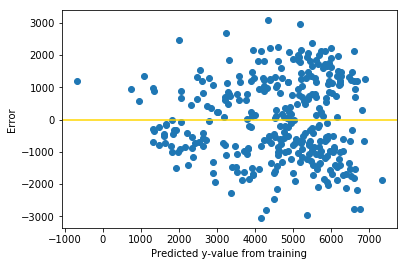

In [21]:
# residual plot
e = y_train - train_predict
plt.scatter(train_predict, e)
plt.xlabel("Predicted y-value from training")
plt.ylabel("Error")
plt.axhline(0, color='gold');

Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 
<br> 
TThe plot reveals that the relationship between the predictors and the response is non-linear given that there appears to still be a pattern between the two axes. As the predicted y-value from training increases, the error increases in magnitude, both in the positive and negative directions. So the variance, the squared deviation of the error terms from zero, increases as the predicted y-value from training increases.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [22]:
predictors = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'spring', 'summer', 'fall', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Clear', 'Cloudy']

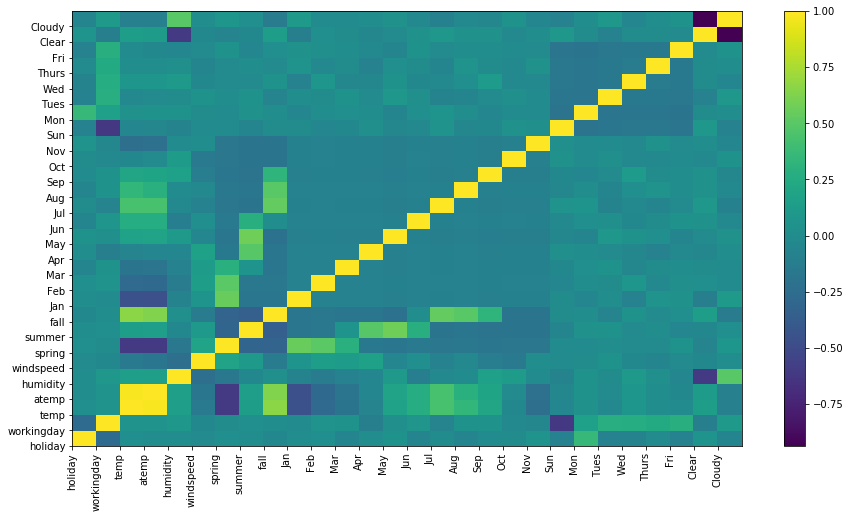

In [23]:
# your code here
fig, ax = plt.subplots(1, 1, figsize=(15,8))
corr = np.corrcoef(x_train.T)
pd.DataFrame(corr).head()
plt.pcolor(corr)
plt.colorbar();
#ax.set_yticks(range(len(predictors)));
ax.set_yticks(np.arange(0,len(predictors),1))
ax.set_yticklabels(predictors)

ax.set_xticks(np.arange(0,len(predictors),1))
ax.set_xticklabels(predictors, rotation='vertical')
#ax.set_ylabels(predictors)
plt.show()

Are there predictors that fall into natural groups based on the correlation values?
<br> 
The squares that are closest to the yellow color mean that the relationship between the predictor in the x axis and y axis are strongly correlated. Of course, as it can be clearly seen, the predictor with itself will be strongly correlated. Apart from that, it seems as though temp and atemp are strongly correlated, as well as fall and temp, and cloudy and humidity. 

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [24]:
x_train.head()

,holiday,workingday,temp,atemp,humidity,windspeed,spring,summer,fall,Jan,...,Oct,Nov,Sun,Mon,Tues,Wed,Thurs,Fri,Clear,Cloudy
0,0.0,1.0,0.624743,0.651090,0.922058,-0.930164,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,1.0,-0.180583,-0.054841,0.697907,-0.213825,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.0,1.0,0.803704,0.852785,-0.449062,0.805143,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0.0,0.0,-1.522794,-1.567551,-0.332616,-0.269507,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,1.0,0.535262,0.348548,1.978781,-1.200843,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
regression_model = LinearRegression(fit_intercept=True)

In [26]:
# function to get the Bayes info criterion (BIC)
def get_bic(X_train, y_train):
    X_train = add_constant(X_train)
    # linear regression for x_train and y_train
    model = sm.OLS(y_train, X_train).fit()
    return model.bic

In [27]:
# STEP-WISE BACKWARD SELECTION
all_pred = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'spring', 'summer', 'fall', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Clear', 'Cloudy']
# x_train has initially all the predictors
X_train = df_train1[all_pred].values
predictors = [(all_pred, get_bic(X_train, y_train))]

for k in range(len(all_pred), 1, -1):
    best_k_predictors = predictors[-1][0]
    bics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = df_train1[k_minus_1].values

        bics.append(get_bic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(bics)]]))
    predictors.append((best_k_minus_1, np.min(bics)))

In [28]:
# extracting the best predictors selected with BIC
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = df_train1[best_predictor_set[0]].values  
X_test = df_test1[best_predictor_set[0]].values
# fitting the x_test with the selected predictors
regression_model.fit(X_train, y_test)
print('Predictor set chosen by BIC: {}\nbic: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))


Predictor set chosen by BIC: ['humidity', 'windspeed', 'Jul', 'spring', 'Aug', 'temp', 'Jun']
bic: 5741.129804641548
test R^2: 0.27869878563850436


Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)?
<br>
As shown in part (c), temp and atemp are strongly correlated between each other. In part (d) only one of the two is selected, which means that the model was able to eliminate the redundant predictor atemp.

How do the test  R^2  scores for the fitted models compare with the model fitted in Part (b) using all predictors?
<br>
IN this section, we implemented a step-wise forward selection with only a chosen set of predictors through BIC: temp, august, humidity, windspeed, spring, july, and june. The test R^2 came out to be approximately 0.28. In part (c), however, we used a linear model with all the predictors, which resulted in a R^2 of approximately 0.26. The step-wise backward selection slightly improved the R^2 score.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
dx_train = df_train1[['temp', 'humidity', 'windspeed', 'spring', 'Jun', 'Jul', 'Aug']]

In [41]:
# cross validation loop
datasets = [x_train, dx_train]
n_folds = 10
r2s =[]
c = 0
for x in datasets:
    for train, valid in KFold(n_folds, shuffle=False).split(range(331)): # split data into train/test groups, 10 times
        nx_train = x.values[train]
        ny_train = y_train[train]
        nx_valid = x.values[valid]
        ny_valid = y_train[valid]
        X_2 = sm.add_constant(nx_train)
        X_3 = sm.add_constant(nx_valid)
        nregr_sm = sm.OLS(ny_train, X_2)
        nresults_OLS = nregr_sm.fit()
        test_predict = nresults_OLS.predict(X_3)
        r2s.append(r2_score(ny_valid, test_predict))
    if c == 0:
        print("average r^2 with all predictors:", np.mean(r2s))
    else:
        print("average r^2 with stepwise backward selected subset:", np.mean(r2s))
    c += 1
    r2s = []

average r^2 with all predictors: 0.34257855094
average r^2 with stepwise backward selected subset: 0.4488377519


### Part e Answers (1)
- The average R^2 for the subset of predictors obtained using stepwise backward selection with BIC was significantly higher than that of the model with all the predictors. This makes sense because a subset of the predictors will have removed many of the predictors that have high p-values and aren't significant, which will make the model more accurate.

In [40]:
# We use the cross_val_score method from sklearn as a sense check here
r2s = cross_val_score(LinearRegression(), x_train.values, y_train, cv = 10)
print(r2s.mean())
r2sd = cross_val_score(LinearRegression(), dx_train.values, y_train, cv = 10)
print(r2sd.mean())

0.344879247959
0.4488377519


In [43]:
dx_test = df_test1[['temp', 'humidity', 'windspeed', 'spring', 'Jun', 'Jul', 'Aug']]
#add constants
X_4 = sm.add_constant(dx_test)
X_5 = sm.add_constant(x_test)
X_6 = sm.add_constant(dx_train)
X_7 = sm.add_constant(x_train)
#fit models with the full training data
allp_regr_sm = sm.OLS(y_train, X_7)
subset_regr_sm = sm.OLS(y_train, X_6)
allp_results = allp_regr_sm.fit()
subset_results = subset_regr_sm.fit()
#make predictions and score
allp_predict = allp_results.predict(X_5)
subset_predict = subset_results.predict(X_4)
print("R^2 of all predictors on left out test set:", r2_score(y_test, allp_predict))
print("R^2 of subset on left out test set:", r2_score(y_test, subset_predict))

R^2 of all predictors on left out test set: 0.257879230085
R^2 of subset on left out test set: 0.245612871146


### Part e Answers (2)
- The results do not agree with the cross validation. This is most likely because the provided test set is 69 rows (18%) larger than our training set, so it is likely that our training set does not capture some of the trends of this large test set. Since our subset selection is based upon our small training set it makes sense that the subset has a worse R^2 value than our model that uses all predictors, because it could be leaving out predictors that are important to the large test set.